# Evaluation

In [2]:
import sys
sys.path.append('..')
sys.path.append('../stylegan3')

import os
import pickle
import h5py

import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from models.MultilabelResnetClassifier import MultilabelResnetClassifier

from tqdm import tqdm

from stylegan_generator import StyleGANGenerator
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
generator = StyleGANGenerator(network_pkl)

class MovingLatentA(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.name = 'moving_latent_a'
        self.shifter = nn.Sequential(
            nn.Linear(512+n_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512))            
        
    def forward(self, x, features):
        return self.shifter(torch.cat((features, x), dim=1))
    
class LatentAutoEncoderC(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name = 'latent_autoencoder_c'
        self.encoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512))
        
        self.feature = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,512),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)) 
        
    def forward(self, x, y):
        latent = self.encoder(x)
        feature = self.feature(y)
        x = self.decoder(torch.cat((feature, latent),1))
        return x,latent
    

model_ae = LatentAutoEncoderC().cuda()
save_filename = 'latent_autoencoder_c_multilabel.pt'
model_ae.load_state_dict(torch.load(save_filename))

model_eyeglasses = MovingLatentA(1).cuda()
save_filename = 'moving_latent_a_eyeglasses.pt'
model_eyeglasses.load_state_dict(torch.load(save_filename))

model_male = MovingLatentA(1).cuda()
save_filename = 'moving_latent_a_male.pt'
model_male.load_state_dict(torch.load(save_filename))

model_black_hair = MovingLatentA(1).cuda()
save_filename = 'moving_latent_a_black_hair.pt'
model_black_hair.load_state_dict(torch.load(save_filename))

with open('/home/robert/data/diploma-thesis/datasets/features/eyeglasses_feature_direction.pkl', 'rb') as f:
    eyeglasses_feature_axis = pickle.load(f)[:]

with open('/home/robert/data/diploma-thesis/datasets/features/male_feature_direction.pkl', 'rb') as f:
    male_feature_axis = pickle.load(f)[:]

with open('/home/robert/data/diploma-thesis/datasets/features/black_hair_feature_direction.pkl', 'rb') as f:
    black_hair_feature_axis = pickle.load(f)[:]


def plot_rows(to_plot):
    columns = len(to_plot[0]) # images
    rows = len(to_plot)
    fig = plt.figure(figsize=(columns, rows+2))
    fig.tight_layout()
    # for each image feature
    for i in range(rows):
        # for each image in current feature
        
        for j in range(columns):
            plt.axis('off')
    
            ax = fig.add_subplot(rows, columns, i*columns+j+1)
            if j == 5:
                if i == 0:
                    ax.set_title('original')
                if i == 1:
                    ax.set_title('baseline')
                if i == 2:
                    ax.set_title('autoencoder')
                if i == 3:
                    ax.set_title('moving latent vector')
            
            
            # right next to each other
    
            plt.imshow(to_plot[i][j]/255) # show image

            plt.subplots_adjust(wspace=0.0, hspace=0.0) 


    plt.axis('off')
    plt.show()

def predict(model, dataloader):
    preds = np.array([])
    model.eval()
    with torch.no_grad():
        for X, _ in tqdm(dataloader):
            X = X.cuda()
            if preds.size == 0:
                preds = model(X).cpu().numpy()
            else:
                preds = np.concatenate((preds, model(X).cpu().numpy()), axis=0)

    return preds

### Manual evaluation

#### Single feature

In [101]:
# rnd = np.random.RandomState(123) # black hair
# rnd = np.random.RandomState(321) # eyeglasses + male
rnd = np.random.RandomState(3210) # eyeglasses
latents = rnd.randn(11, 512)

model_eyeglasses.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses = model_eyeglasses(x, labels).cpu().numpy()

model_male.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_male = model_male(x, labels).cpu().numpy()

model_black_hair.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_black_hair = model_black_hair(x, labels).cpu().numpy()

model_ae.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels_eyeglasses = torch.squeeze(torch.dstack((torch.ones(len(x)), torch.zeros(len(x)), torch.zeros(len(x))))).cuda()
    ae_eyeglasses, _ = model_ae(x, labels_eyeglasses)

    labels_male = torch.squeeze(torch.dstack((torch.zeros(len(x)), torch.ones(len(x)), torch.zeros(len(x))))).cuda()
    ae_male, _ = model_ae(x, labels_male)

    labels_black_hair = torch.squeeze(torch.dstack((torch.zeros(len(x)), torch.zeros(len(x)), torch.ones(len(x))))).cuda()
    ae_black_hair, _ = model_ae(x, labels_black_hair)


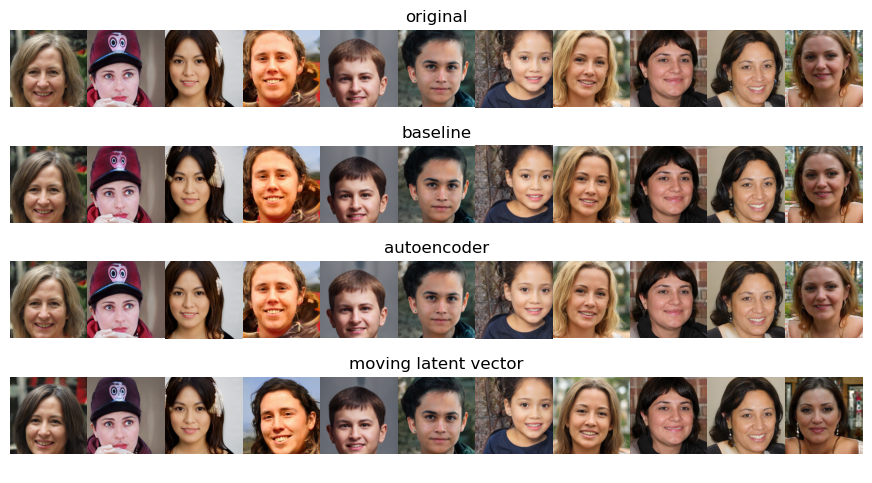

In [95]:
imgs_orig = generator.generate_from(latents, truncation_psi=0.7)

imgs_eyeglasses_baseline = generator.generate_from(latents + eyeglasses_feature_axis, truncation_psi=0.7)
imgs_eyeglasses_ae = generator.generate_from(ae_eyeglasses, truncation_psi=0.7)
imgs_eyeglasses_moved = generator.generate_from(moved_eyeglasses, truncation_psi=0.7)

imgs_male_baseline = generator.generate_from(latents + male_feature_axis, truncation_psi=0.7)
imgs_male_ae = generator.generate_from(ae_male, truncation_psi=0.7)
imgs_male_moved = generator.generate_from(moved_male, truncation_psi=0.7)

imgs_black_hair_baseline = generator.generate_from(latents + black_hair_feature_axis, truncation_psi=0.7)
imgs_black_hair_ae = generator.generate_from(ae_black_hair, truncation_psi=0.7)
imgs_black_hair_moved = generator.generate_from(moved_black_hair, truncation_psi=0.7)

# to_plot = [imgs_orig, 
#            imgs_eyeglasses_baseline, imgs_eyeglasses_ae, imgs_eyeglasses_moved, 
#            imgs_male_baseline, imgs_male_ae, imgs_male_moved, 
#            imgs_black_hair_baseline, imgs_black_hair_ae, imgs_black_hair_moved]

# to_plot = [imgs_orig, imgs_eyeglasses_baseline, imgs_eyeglasses_ae, imgs_eyeglasses_moved]
# to_plot = [imgs_orig, imgs_male_baseline, imgs_male_ae, imgs_male_moved]
to_plot = [imgs_orig, imgs_black_hair_baseline, imgs_black_hair_ae, imgs_black_hair_moved]
plot_rows(to_plot)

#### Multiple features

#### Eyeglasses + Male

In [110]:
# rnd = np.random.RandomState(123) # black hair
# rnd = np.random.RandomState(321) # eyeglasses + male
rnd = np.random.RandomState(3210) # eyeglasses
latents = rnd.randn(11, 512)

model_eyeglasses.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses = model_eyeglasses(x, labels).cpu().numpy()

model_male.eval()
with torch.no_grad():
    x = torch.Tensor(moved_eyeglasses).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses_male = model_male(x, labels).cpu().numpy()

model_ae.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels_eyeglasses_male = torch.squeeze(torch.dstack((torch.ones(len(x)), torch.ones(len(x)), torch.zeros(len(x))))).cuda()
    ae_eyeglasses_male, _ = model_ae(x, labels_eyeglasses)


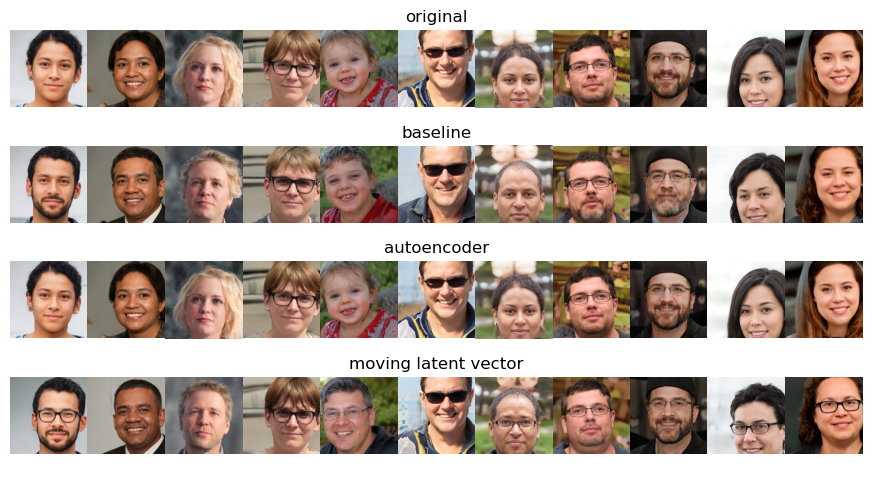

In [112]:
imgs_orig = generator.generate_from(latents, truncation_psi=0.7)

imgs_eyeglasses_male_baseline = generator.generate_from(latents + eyeglasses_feature_axis + male_feature_axis, truncation_psi=0.7)
imgs_eyeglasses_male_ae = generator.generate_from(ae_eyeglasses_male, truncation_psi=0.7)
imgs_eyeglasses_male_moved = generator.generate_from(moved_eyeglasses_male, truncation_psi=0.7)

to_plot = [imgs_orig, imgs_eyeglasses_male_baseline, imgs_eyeglasses_male_ae, imgs_eyeglasses_male_moved]
plot_rows(to_plot)

#### Eyeglasses + Male + Black Hair

In [125]:
model_eyeglasses.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses = model_eyeglasses(x, labels).cpu().numpy()

model_male.eval()
with torch.no_grad():
    x = torch.Tensor(moved_eyeglasses).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses_male = model_male(x, labels).cpu().numpy()

model_black_hair.eval()
with torch.no_grad():
    x = torch.Tensor(moved_eyeglasses_male).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses_male_bh = model_black_hair(x, labels).cpu().numpy()

model_ae.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels_eyeglasses = torch.squeeze(torch.dstack((torch.ones(len(x)), torch.ones(len(x)), torch.ones(len(x))))).cuda()
    ae_eyeglasses_male_bh, _ = model_ae(x, labels_eyeglasses)

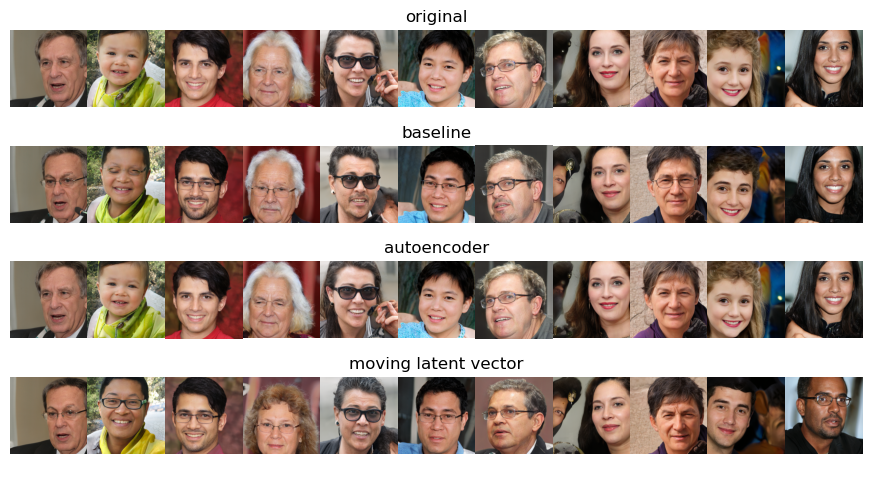

In [127]:
imgs_orig = generator.generate_from(latents, truncation_psi=0.7)

imgs_eyeglasses_male_bh_baseline = generator.generate_from(latents + eyeglasses_feature_axis + male_feature_axis + black_hair_feature_axis, truncation_psi=0.7)
imgs_eyeglasses_male_bh_ae = generator.generate_from(ae_eyeglasses_male_bh, truncation_psi=0.7)
imgs_eyeglasses_male_bh_moved = generator.generate_from(moved_eyeglasses_male_bh, truncation_psi=0.7)

to_plot = [imgs_orig, imgs_eyeglasses_male_bh_baseline, imgs_eyeglasses_male_bh_ae, imgs_eyeglasses_male_bh_moved]
plot_rows(to_plot)

### Evaluation using ResNet34

#### Single feature

In [2]:
rnd = np.random.RandomState(123)
latents = rnd.randn(1000, 512)

In [3]:
save_path = '/home/robert/data/diploma-thesis/eva/latents/'

all_features = []

feature = 'orignal'
all_features.append(feature)
with h5py.File(save_path + feature + '.h5', 'w') as f:
       f.create_dataset('z', data=latents)

feature = 'baseline_eyeglasses'
all_features.append(feature)
baseline_eyeglasses = latents + eyeglasses_feature_axis
with h5py.File(save_path + feature + '.h5', 'w') as f:
       f.create_dataset('z', data=baseline_eyeglasses)

feature = 'baseline_male'
all_features.append(feature)
baseline_male = latents + male_feature_axis
with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=baseline_male)

feature = 'baseline_black_hair'
all_features.append(feature)
baseline_black_hair = latents + black_hair_feature_axis
with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=baseline_black_hair)

feature = 'mlv_eyeglasses'
all_features.append(feature)
model_eyeglasses.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses = model_eyeglasses(x, labels).cpu().numpy()
    with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=moved_eyeglasses)

feature = 'mlv_male'
all_features.append(feature)
model_male.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_male = model_male(x, labels).cpu().numpy()
    with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=moved_male)

feature = 'mlv_black_hair'
all_features.append(feature)
model_black_hair.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_black_hair = model_black_hair(x, labels).cpu().numpy()
    with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=moved_black_hair)

model_ae.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()

    feature = 'ae_eyeglasses'
    all_features.append(feature)
    labels = torch.squeeze(torch.dstack((torch.ones(len(x)), torch.zeros(len(x)), torch.zeros(len(x))))).cuda()
    ae_eyeglasses, _ = model_ae(x, labels)
    ae_eyeglasses = ae_eyeglasses.cpu().numpy()
    with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=ae_eyeglasses)

    feature = 'ae_male'
    all_features.append(feature)
    labels = torch.squeeze(torch.dstack((torch.zeros(len(x)), torch.ones(len(x)), torch.zeros(len(x))))).cuda()
    ae_male, _ = model_ae(x, labels)
    ae_male = ae_male.cpu().numpy()
    with h5py.File(save_path + feature + '.h5', 'w') as f:
       f.create_dataset('z', data=ae_male)

    feature = 'ae_black_hair'
    all_features.append(feature)
    labels = torch.squeeze(torch.dstack((torch.zeros(len(x)), torch.zeros(len(x)), torch.ones(len(x))))).cuda()
    ae_black_hair, _ = model_ae(x, labels)
    ae_black_hair = ae_black_hair.cpu().numpy()
    with h5py.File(save_path + feature + '.h5', 'w') as f:
        f.create_dataset('z', data=ae_black_hair)


#### Eyeglasses + Male

In [5]:
feature = 'mlv_eyeglasses_male'
all_features.append(feature)
model_eyeglasses.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses = model_eyeglasses(x, labels).cpu().numpy()

model_male.eval()
with torch.no_grad():
    x = torch.Tensor(moved_eyeglasses).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses_male = model_male(x, labels).cpu().numpy()

with h5py.File(save_path + feature + '.h5', 'w') as f:
    f.create_dataset('z', data=moved_eyeglasses_male)

feature = 'ae_eyeglasses_male'
all_features.append(feature)
model_ae.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.squeeze(torch.dstack((torch.ones(len(x)), torch.ones(len(x)), torch.zeros(len(x))))).cuda()
    ae_eyeglasses_male, _ = model_ae(x, labels)
    ae_eyeglasses_male = ae_eyeglasses_male.cpu().numpy()

with h5py.File(save_path + feature + '.h5', 'w') as f:
    f.create_dataset('z', data=ae_eyeglasses_male)

feature = 'baseline_eyeglasses_male'
all_features.append(feature)
baseline_eyeglasses_male = latents + eyeglasses_feature_axis + male_feature_axis
with h5py.File(save_path + feature + '.h5', 'w') as f:
       f.create_dataset('z', data=baseline_eyeglasses_male)

#### Eyeglasses + Male + Black hair

In [6]:
feature = 'mlv_eyeglasses_male_bh'
all_features.append(feature)
model_eyeglasses.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses = model_eyeglasses(x, labels).cpu().numpy()

model_male.eval()
with torch.no_grad():
    x = torch.Tensor(moved_eyeglasses).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses_male = model_male(x, labels).cpu().numpy()

model_black_hair.eval()
with torch.no_grad():
    x = torch.Tensor(moved_eyeglasses_male).cuda()
    labels = torch.ones(len(x),1).cuda()
    moved_eyeglasses_male_bh = model_black_hair(x, labels).cpu().numpy()

with h5py.File(save_path + feature + '.h5', 'w') as f:
    f.create_dataset('z', data=moved_eyeglasses_male_bh)

feature = 'ae_eyeglasses_male_bh'
all_features.append(feature)
model_ae.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.squeeze(torch.dstack((torch.ones(len(x)), torch.ones(len(x)), torch.ones(len(x))))).cuda()
    ae_eyeglasses_male_bh, _ = model_ae(x, labels)
    ae_eyeglasses_male_bh = ae_eyeglasses_male_bh.cpu().numpy()

with h5py.File(save_path + feature + '.h5', 'w') as f:
    f.create_dataset('z', data=ae_eyeglasses_male_bh)

feature = 'baseline_eyeglasses_male_bh'
all_features.append(feature)
baseline_eyeglasses_male_bh = latents + eyeglasses_feature_axis + male_feature_axis + black_hair_feature_axis
with h5py.File(save_path + feature + '.h5', 'w') as f:
       f.create_dataset('z', data=baseline_eyeglasses_male_bh)

In [7]:
for f in all_features:
    n_batch = 100
    batch_size = 10
    outdir = '/home/robert/data/diploma-thesis/eva/imgs/' + f + '/'
    truncation_psi = 0.7
    z_path = '/home/robert/data/diploma-thesis/eva/latents/' + f + '.h5'

    generator.generate_images_from_z(z_path, n_batch, batch_size, outdir, truncation_psi=truncation_psi)

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
save_filename = '/home/robert/data/diploma-thesis/weights/classfier/resnet34_celeba10attr_10e.pt'

model = MultilabelResnetClassifier(n_classes=10).cuda()
model.load_state_dict(torch.load(save_filename))

for f in all_features:
    path_to_data = '/home/robert/data/diploma-thesis/eva/imgs/' + f + '/imgs'
    transform = transforms.Compose([transforms.ToTensor()])

    dataset = datasets.ImageFolder(path_to_data, transform=transform)

    batch_size = 64
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    preds = predict(model=model, dataloader=dataloader)

    preds_path = '/home/robert/data/diploma-thesis/eva/predictions/' + f + '.pkl'
    os.makedirs('/home/robert/data/diploma-thesis/eva/predictions/', exist_ok=True)
    with open(preds_path, 'wb') as ff:
        pickle.dump(preds, ff)

100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


In [10]:
for ff in all_features:
    preds_path = '/home/robert/data/diploma-thesis/eva/predictions/' + ff + '.pkl'
    with open(preds_path, 'rb') as f:
        preds = pickle.load(f)
        print(ff)
        print('eyeglasses count:', preds[:,1].round().sum(), 'male count:', preds[:,3].round().sum(), 'black_hair count:', preds[:,4].round().sum())
        print()
        

orignal
eyeglasses count: 86.0 male count: 639.0 black_hair count: 115.0

baseline_eyeglasses
eyeglasses count: 306.0 male count: 766.0 black_hair count: 94.0

baseline_male
eyeglasses count: 159.0 male count: 890.0 black_hair count: 81.0

baseline_black_hair
eyeglasses count: 78.0 male count: 611.0 black_hair count: 284.0

mlv_eyeglasses
eyeglasses count: 540.0 male count: 836.0 black_hair count: 78.0

mlv_male
eyeglasses count: 117.0 male count: 890.0 black_hair count: 101.0

mlv_black_hair
eyeglasses count: 74.0 male count: 623.0 black_hair count: 294.0

ae_eyeglasses
eyeglasses count: 96.0 male count: 649.0 black_hair count: 113.0

ae_male
eyeglasses count: 92.0 male count: 650.0 black_hair count: 118.0

ae_black_hair
eyeglasses count: 93.0 male count: 643.0 black_hair count: 117.0

mlv_eyeglasses_male
eyeglasses count: 596.0 male count: 969.0 black_hair count: 51.0

ae_eyeglasses_male
eyeglasses count: 92.0 male count: 661.0 black_hair count: 117.0

mlv_eyeglasses_male
eyeglasses 

In [22]:
from torchmetrics.functional import mean_squared_error

all_features = ['orignal',
                'baseline_eyeglasses', 'baseline_male', 'baseline_black_hair',
                'mlv_eyeglasses', 'mlv_male', 'mlv_black_hair',
                'ae_eyeglasses', 'ae_male', 'ae_black_hair',
                'mlv_eyeglasses_male', 'ae_eyeglasses_male', 'baseline_eyeglasses_male',
                'mlv_eyeglasses_male_bh', 'ae_eyeglasses_male_bh', 'baseline_eyeglasses_male_bh'
                ]

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64
dataloader_orig = DataLoader(datasets.ImageFolder('/home/robert/data/diploma-thesis/eva/imgs/orignal/imgs', transform=transform), batch_size=batch_size, shuffle=False)


for f in all_features:
    dataloader = DataLoader(datasets.ImageFolder('/home/robert/data/diploma-thesis/eva/imgs/' + f + '/imgs', transform=transform), batch_size=batch_size, shuffle=False)

    orig_iter = iter(dataloader_orig)

    sum_mse = 0
    for (data, _) in dataloader:
        orig_data = next(orig_iter)[0]
        sum_mse += mean_squared_error(orig_data, data)

    print(f +' MSE: ' + str(sum_mse.numpy()/len(dataloader)))

orignal MSE: 0.0
baseline_eyeglasses MSE: 0.013789390213787556
baseline_male MSE: 0.020695960149168968
baseline_black_hair MSE: 0.020908134058117867
mlv_eyeglasses MSE: 0.032727863639593124
mlv_male MSE: 0.03422890976071358
mlv_black_hair MSE: 0.03520980104804039
ae_eyeglasses MSE: 0.005895717069506645
ae_male MSE: 0.00583410682156682
ae_black_hair MSE: 0.005881005432456732
mlv_eyeglasses_male MSE: 0.0464337095618248
ae_eyeglasses_male MSE: 0.005873227491974831
baseline_eyeglasses_male MSE: 0.028763197362422943
mlv_eyeglasses_male_bh MSE: 0.05745304748415947
ae_eyeglasses_male_bh MSE: 0.005856696050614119
baseline_eyeglasses_male_bh MSE: 0.035061612725257874
